In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from tqdm import tqdm
import random

In [3]:
RANDOM_SEED = 69
random.seed(RANDOM_SEED)

In [4]:
all_labels = pd.read_csv('./data/train_data.csv')

In [5]:
TRAIN_SIZE = 0.85
split_index = round(all_labels.id.count() * TRAIN_SIZE)

In [6]:
train_labels = all_labels.loc[0:split_index - 1]
test_labels = all_labels.loc[split_index:]
train_images = all_labels.loc[0:split_index-1]['id']
train_labels = all_labels.loc[0:split_index-1]['boneage']
test_images = all_labels.loc[split_index:]['id']
test_labels = all_labels.loc[split_index:]['boneage']

In [7]:
print(f'Train amount: {len(train_labels)}')
print(f'Test amount: {len(test_labels)}')

Train amount: 10719
Test amount: 1892


### Aplicación de Filtro Gaussian Blur

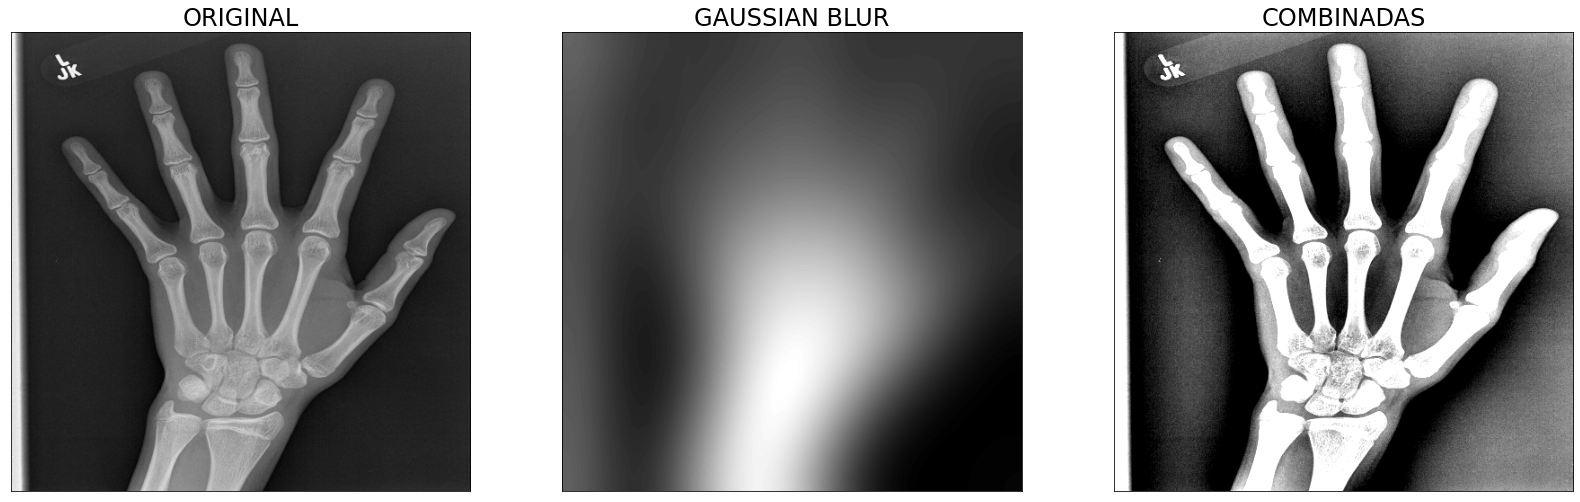

In [12]:
IMG_SIZE = 512
path = './data/train_img/boneage-training-dataset/1377.png'

GAUSS_KERNEL_SIZE = (0, 0)
GAUSS_SIGMA_X = 50
WEIGHT = 4

original_img = cv2.imread(path)
original_img = cv2.resize(original_img, (IMG_SIZE, IMG_SIZE))
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

def apply_gauss_blur(img, ksize=(0,0), sigma_x=50, gamma=128):
    """
    Aplicar Gaussian Blur a img.
    """
    gauss = cv2.GaussianBlur(img, ksize, sigma_x)
    img = cv2.addWeighted(img, WEIGHT, gauss, -WEIGHT, gamma)
    
    return img

filtered_img = apply_gauss_blur(original_img)
blurred_img = cv2.GaussianBlur(original_img, GAUSS_KERNEL_SIZE, GAUSS_SIGMA_X)

fontdict = {'fontsize':24}
fig = plt.figure(figsize=(28, 28))
ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
ax.set_title('ORIGINAL', fontdict)
plt.imshow(original_img, cmap='gray')
ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
ax.set_title('GAUSSIAN BLUR', fontdict)
plt.imshow(blurred_img, cmap='gray')
ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
ax.set_title('COMBINADAS', fontdict)
plt.imshow(filtered_img, cmap='gray')

### Preprocesamiento de Imágenes
- NOTA: ejecutar únicamente una vez.
- Para cada imagen del dataset de entrenamiento, se aplica el filtro Gaussiano y se recorta la imagen.
- Cada imagen procesada se guarda en un folder separado, para poder utilizarla posteriormente en el entrenamiento del modelo.

In [ ]:
for i in tqdm(range(len(train_images))):
    img_id = train_images.loc[i]
    img = cv2.imread(f'./data/train_img/boneage-training-dataset/{img_id}.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = apply_gauss_blur(img)
    img = cv2.resize(img, (128, 128))
    cv2.imwrite(f'./data/preprocessed/train/{img_id}.png', img)

 23%|██▎       | 2509/10719 [15:15<1:00:55,  2.25it/s]

In [14]:
for img_id in tqdm(test_images):
    img = cv2.imread(f'./data/train_img/boneage-training-dataset/{img_id}.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = apply_gauss_blur(img)
    img = cv2.resize(img, (128, 128))
    cv2.imwrite(f'./data/preprocessed/test/{img_id}.png', img)

100%|██████████| 1892/1892 [11:26<00:00,  2.76it/s]


### Lectura de Imágenes Preprocesadas

In [8]:
train_img_x = []
for img_id in tqdm(train_images):
    train_img_x.append(cv2.imread(f'./data/preprocessed/train/{img_id}.png'))

train_img_x = np.array(train_img_x)

100%|██████████| 10719/10719 [00:04<00:00, 2218.21it/s]


In [9]:
test_img_x = []
for img_id in tqdm(test_images):
    test_img_x.append(cv2.imread(f'./data/preprocessed/test/{img_id}.png'))

test_img_x = np.array(test_img_x)

100%|██████████| 1892/1892 [00:00<00:00, 2179.11it/s]


Normalizar valores de [0, 255] a [0, 1]

In [10]:
train_img_x = train_img_x / 255.0
test_img_x = test_img_x / 255.0

## Modelo Simple sin capas de convolución

In [11]:
simple_model_0 = tf.keras.Sequential()
simple_model_0.add(layers.Flatten(input_shape=(128, 128, 3)))
simple_model_0.add(layers.Dense(512))
simple_model_0.add(layers.Dense(229))
simple_model_0.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])
simple_model_0_hist = simple_model_0.fit(train_img_x, train_labels, epochs=10,
                   validation_data=(test_img_x, test_labels))

Epoch 1/10
335/335 [==============================] - 31s 94ms/step - loss: 132.2443 - accuracy: 0.0430 - val_loss: 95.6335 - val_accuracy: 0.0127
Epoch 2/10
335/335 [==============================] - 31s 93ms/step - loss: 117.9271 - accuracy: 0.0463 - val_loss: 95.9969 - val_accuracy: 0.0840
Epoch 3/10
335/335 [==============================] - 32s 95ms/step - loss: 74.5110 - accuracy: 0.0606 - val_loss: 61.9811 - val_accuracy: 0.0455
Epoch 4/10
335/335 [==============================] - 31s 94ms/step - loss: 58.4699 - accuracy: 0.0670 - val_loss: 55.2904 - val_accuracy: 0.0539
Epoch 5/10
335/335 [==============================] - 31s 94ms/step - loss: 45.2940 - accuracy: 0.0826 - val_loss: 37.9064 - val_accuracy: 0.0164
Epoch 6/10
335/335 [==============================] - 31s 93ms/step - loss: 38.1027 - accuracy: 0.0855 - val_loss: 36.9618 - val_accuracy: 0.0973
Epoch 7/10
335/335 [==============================] - 31s 93ms/step - loss: 37.4064 - accuracy: 0.0921 - val_loss: 39.6477

### Modelo simple 2

In [12]:
simple_model_1 = tf.keras.Sequential()
simple_model_1.add(layers.Flatten(input_shape=(128, 128, 3)))
simple_model_1.add(layers.Dense(128))
simple_model_1.add(layers.Dense(256))
simple_model_1.add(layers.Dense(229))
simple_model_1.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])
simple_model_1_hist = simple_model_1.fit(train_img_x, train_labels, epochs=10,
                   validation_data=(test_img_x, test_labels))

Epoch 1/10
335/335 [==============================] - 9s 27ms/step - loss: 35.7716 - accuracy: 0.0437 - val_loss: 12.3992 - val_accuracy: 0.0439
Epoch 2/10
335/335 [==============================] - 9s 26ms/step - loss: 9.5671 - accuracy: 0.0639 - val_loss: 7.5469 - val_accuracy: 0.0296
Epoch 3/10
335/335 [==============================] - 9s 26ms/step - loss: 5.2452 - accuracy: 0.0818 - val_loss: 4.2686 - val_accuracy: 0.0714
Epoch 4/10
335/335 [==============================] - 9s 26ms/step - loss: 10.8462 - accuracy: 0.0841 - val_loss: 47.6317 - val_accuracy: 0.0544
Epoch 5/10
335/335 [==============================] - 9s 26ms/step - loss: 59.9904 - accuracy: 0.0426 - val_loss: 32.8170 - val_accuracy: 0.0555
Epoch 6/10
335/335 [==============================] - 8s 25ms/step - loss: 13.5529 - accuracy: 0.0647 - val_loss: 6.0049 - val_accuracy: 0.0344
Epoch 7/10
335/335 [==============================] - 8s 25ms/step - loss: 7.4841 - accuracy: 0.0830 - val_loss: 10.8129 - val_accuracy

60/60 - 1s - loss: 11.0337 - accuracy: 0.0920
60/60 - 0s - loss: 4.1155 - accuracy: 0.0825


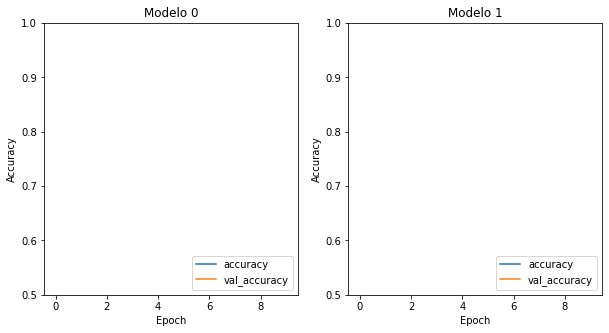

In [13]:
# modelo 0
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(simple_model_0_hist.history['accuracy'], label='accuracy')
ax.plot(simple_model_0_hist.history['val_accuracy'], label = 'val_accuracy')
ax.set_title('Modelo 0')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1])
ax.legend(loc='lower right')
test_loss_0, test_acc_0 = simple_model_0.evaluate(test_img_x,  test_labels, verbose=2)
# modelo 1
ax = fig.add_subplot(1, 2, 2)
ax.plot(simple_model_1_hist.history['accuracy'], label='accuracy')
ax.plot(simple_model_1_hist.history['val_accuracy'], label = 'val_accuracy')
ax.set_title('Modelo 1')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1])
ax.legend(loc='lower right')
test_loss_0, test_acc_1 = simple_model_1.evaluate(test_img_x,  test_labels, verbose=2)
plt.show()

## Modelo con capas de convolución

In [ ]:
conv_model_0 = tf.keras.Sequential()
conv_model_0.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)))
conv_model_0.add(layers.MaxPooling2D((2, 2)))
conv_model_0.add(layers.Conv2D(32, (3, 3), activation='relu'))
conv_model_0.add(layers.MaxPooling2D((2, 2)))
conv_model_0.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model_0.add(layers.MaxPooling2D((2, 2)))
conv_model_0.add(layers.Flatten())
conv_model_0.add(layers.Dense(512, activation='relu'))
conv_model_0.add(layers.Dense(5))

# compilar modelo
conv_model_0.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

# fit
conv_model_0_hist = conv_model_0.fit(train_img_x, train_labels, epochs=20,
                   validation_data=(test_img_x, test_labels))

In [ ]:
conv_model_1 = tf.keras.Sequential()
conv_model_1.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)))
conv_model_1.add(layers.MaxPooling2D((2, 2)))
conv_model_1.add(layers.Conv2D(32, (3, 3), activation='relu'))
conv_model_1.add(layers.MaxPooling2D((2, 2)))
conv_model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model_1.add(layers.MaxPooling2D((2, 2)))
conv_model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model_1.add(layers.MaxPooling2D((2, 2)))
conv_model_1.add(layers.Flatten())
conv_model_1.add(layers.Dense(512, activation='relu'))
conv_model_1.add(layers.Dense(5))

# compilar modelo
conv_model_1.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

# fit
conv_model_1_hist = conv_model_1.fit(train_img_x, train_labels, epochs=20,
                   validation_data=(test_img_x, test_labels))

#### Graficas primer modelo

In [ ]:
# modelo 0
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(conv_model_0_hist.history['accuracy'], label='accuracy')
ax.plot(conv_model_0_hist.history['val_accuracy'], label = 'val_accuracy')
ax.set_title('Modelo 0')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1])
ax.legend(loc='lower right')
test_loss_0, test_acc_0 = conv_model_0.evaluate(test_img_x,  test_labels, verbose=2)
# modelo 1
ax = fig.add_subplot(1, 2, 2)
ax.plot(conv_model_1_hist.history['accuracy'], label='accuracy')
ax.plot(conv_model_1_hist.history['val_accuracy'], label = 'val_accuracy')
ax.set_title('Modelo 1')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1])
ax.legend(loc='lower right')
test_loss_1, test_acc_1 = conv_model_1.evaluate(test_img_x,  test_labels, verbose=2)
plt.show()

## Modelo convolucional con Dropout

In [ ]:
conv_model_2 = tf.keras.Sequential()
conv_model_2.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)))
conv_model_2.add(layers.MaxPooling2D((2, 2)))
conv_model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
conv_model_2.add(layers.MaxPooling2D((2, 2)))
conv_model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model_2.add(layers.MaxPooling2D((2, 2)))
conv_model_2.add(layers.Dropout(0.2)) # Droupout de 20%
conv_model_2.add(layers.Flatten())
conv_model_2.add(layers.Dense(512, activation='relu'))
conv_model_2.add(layers.Dense(5))

# compilar modelo
conv_model_2.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

# fit
conv_model_2_hist = conv_model_2.fit(train_img_x, train_labels, epochs=20,
                   validation_data=(test_img_x, test_labels))



#### Grafica segundo modelo

In [ ]:
acc_2 = conv_model_2_hist.history['accuracy']
val_acc_2 = conv_model_2_hist.history['val_accuracy']
epochs_range = range(20)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Modelo 2')

## Modelo convolucional con Data Augmentation